Part 1: Augmented Reality with Planar Homographies

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


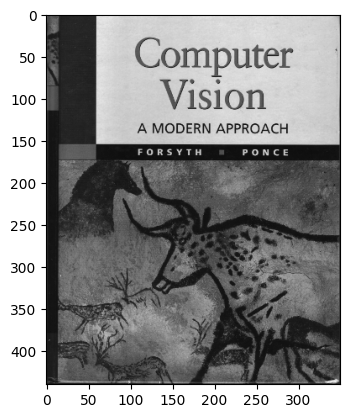

In [85]:
img1 = cv2.imread('/cv_cover.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)

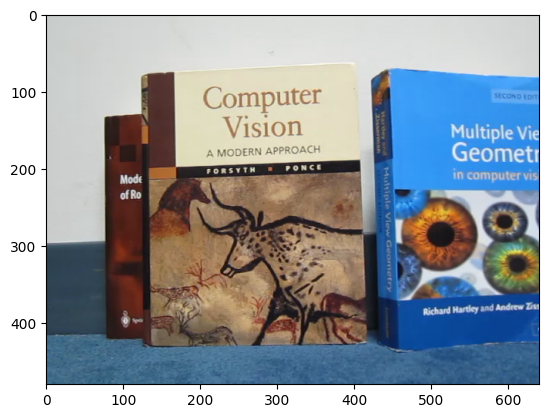

In [86]:
video1 = cv2.VideoCapture('/book.mov')
ret, frame1 = video1.read()
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
video1.release()
plt.imshow(frame1)

### 1.1 Getting Correspondences

 The first step is to find the correspondences between the 2 images
 Using SIFT descriptor from opencv library to find keypoints in each
 image and then use the brute force matcher from opencv to get the correspondences.
 Use the matching way as KNN with size 2, and apply ratio checking between the best 2 matches to filter the good correspondences.
 Choose 50 correspondences and plot the book image, the first video frame and the matches
 as shown below

In [87]:
def find_sift_matches(img1, img2, ratio_threshold = 0.6):

  sift = cv2.SIFT_create()

  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1, des2, k=2)

  good_matches = []
  for m, n in matches:
    if m.distance < n.distance * ratio_threshold:
      good_matches.append(m)

  return kp1, kp2, good_matches

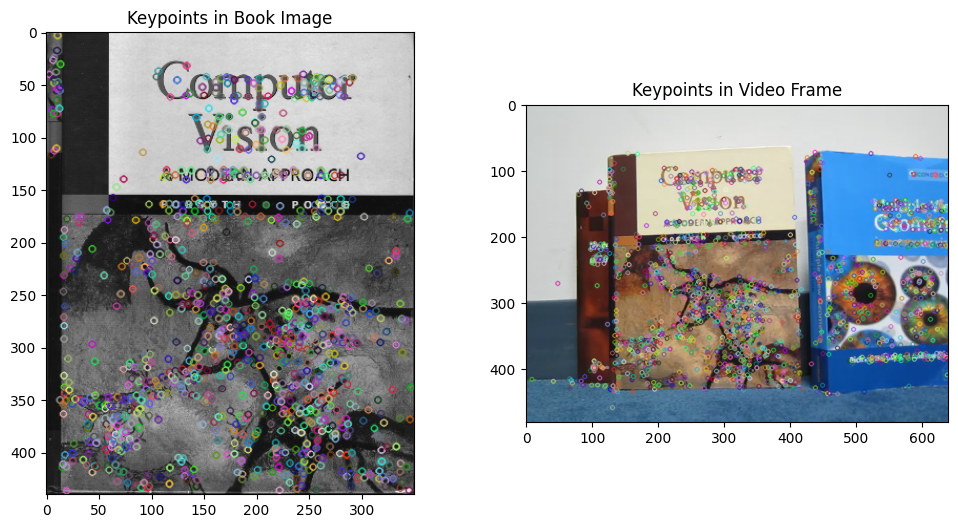

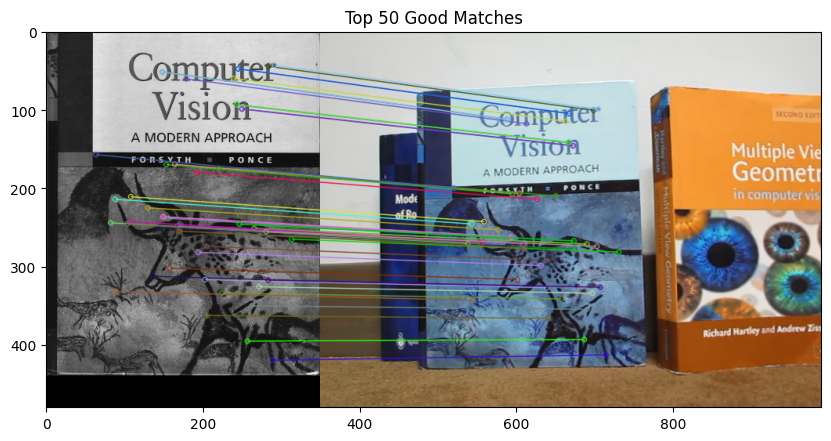

In [88]:
kp1, kp2, good_matches = find_sift_matches(img1, frame1)

good_matches = sorted(good_matches, key=lambda x: x.distance)
good_matches = good_matches[:50]
img1_kp = img1.copy()
frame1_kp = frame1.copy()

img1_kp = cv2.drawKeypoints(img1_kp, kp1, img1_kp)
frame1_kp = cv2.drawKeypoints(frame1_kp, kp2, frame1_kp)
img_matches = cv2.drawMatches(img1, kp1, frame1, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img1_kp)
plt.title("Keypoints in Book Image")

plt.subplot(1, 2, 2)
plt.imshow(frame1_kp)
plt.title("Keypoints in Video Frame")

plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Top 50 Good Matches")
plt.show()






## 1.2 Computing the Homography Parameters

In [89]:
image1_points = []
image2_points = []

for m in good_matches:
  index1 = m.queryIdx
  index2 = m.trainIdx
  keypoint1 = kp1[index1]
  keypoint2 = kp2[index2]
  coordinates1 = keypoint1.pt
  coordiantes2 = keypoint2.pt

  image1_points.append(coordinates1)
  image2_points.append(coordiantes2)

image1_points = np.array(image1_points, dtype=np.float32)
image2_points = np.array(image2_points, dtype=np.float32)

In [90]:
image1_points[:4]

array([[129.84949, 225.25644],
       [149.65019, 236.72469],
       [265.51746, 251.53009],
       [265.51746, 251.53009]], dtype=float32)

In [91]:
image2_points[:4]

array([[226.89275, 253.20773],
       [243.87221, 262.59836],
       [340.44058, 271.5687 ],
       [340.44058, 271.5687 ]], dtype=float32)

In [92]:
def compute_homography(src_pts, dest_pts):

  n = src_pts.shape[0]
  A = []
  b = []

  for i in range(n):
    x, y = src_pts[i][0], src_pts[i][1]
    x_dash, y_dash = dest_pts[i][0], dest_pts[i][1]

    A.append([x, y, 1, 0, 0, 0, -x_dash*x, -x_dash*y])
    A.append([0, 0, 0, x, y, 1, -x*y_dash, -y*y_dash])
    b.append(x_dash)
    b.append(y_dash)

  A = np.array(A)
  b = np.array(b)

  h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
  h = np.append(h, 1)

  H = h.reshape((3, 3))
  return H

### Verification

In [93]:
ones = np.ones((image1_points.shape[0], 1))
image1_points_homogeneous = np.hstack([image1_points, ones])
image1_points_homogeneous[:5]

array([[129.8494873 , 225.25643921,   1.        ],
       [149.65019226, 236.72468567,   1.        ],
       [265.51745605, 251.53009033,   1.        ],
       [265.51745605, 251.53009033,   1.        ],
       [149.65019226, 236.72468567,   1.        ]])

In [94]:
H = compute_homography(image1_points, image2_points)
mapped_points_homogeneous = (H @ image1_points_homogeneous.T).T
mapped_points = mapped_points_homogeneous[:, :2] / mapped_points_homogeneous[:, 2][:, np.newaxis]
mapped_points[:5]


array([[226.96640008, 253.55294343],
       [243.477749  , 262.43806463],
       [340.15205177, 271.46274322],
       [340.15205177, 271.46274322],
       [243.477749  , 262.43806463]])

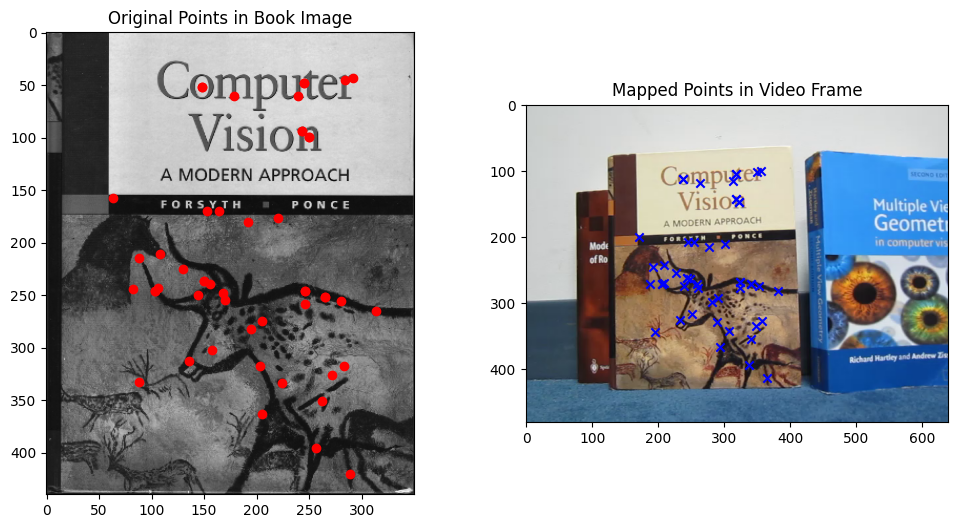

In [95]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(image1_points[:, 0], image1_points[:, 1], color='red', marker='o')
plt.title("Original Points in Book Image")

plt.subplot(1, 2, 2)
plt.imshow(frame1)
plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='blue', marker='x')
plt.title("Mapped Points in Video Frame")

plt.show()

### Effect of Homography Matrix

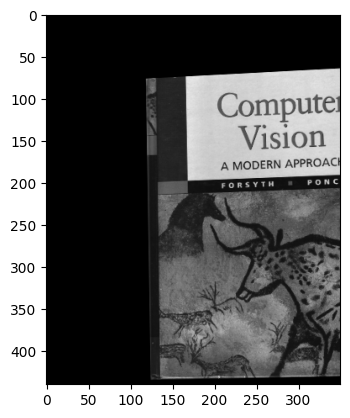

In [96]:
out = cv2.warpPerspective(img1, H, (img1.shape[1], img1.shape[0]))
plt.imshow(out)

### 1.3 Calculate Book Coordinates

In [97]:
height, width = img1.shape[:2]

book_corners = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
    ], dtype = np.float32)

print(book_corners)

[[  0.   0.]
 [349.   0.]
 [349. 439.]
 [  0. 439.]]


In [98]:
book_corners_homogeneous = np.hstack([book_corners, np.ones((4, 1))])
mapped_corners = (H @ book_corners_homogeneous.T).T
mapped_corners = mapped_corners[:, :2] / mapped_corners[:, 2, np.newaxis]

print(mapped_corners)

[[118.69748796  76.65505231]
 [402.00729396  61.67572259]
 [417.34888424 428.87073333]
 [124.4313143  434.24097098]]


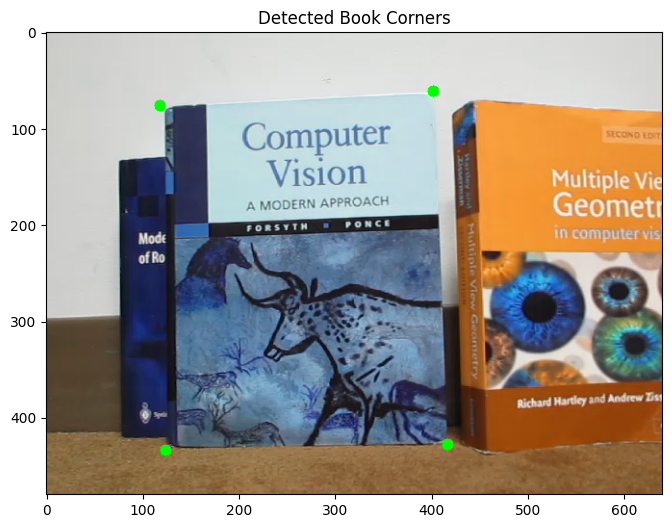

In [99]:
frame_with_corners = frame1.copy()

for point in mapped_corners:
  x, y = int(point[0]), int(point[1])
  cv2.circle(frame_with_corners, (x, y), radius=6, color=(0, 255, 0), thickness=-1)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(frame_with_corners, cv2.COLOR_BGR2RGB))
plt.title("Detected Book Corners")
plt.show()

### 1.4 Crop AR Video Frames

In [100]:
book_width = np.linalg.norm(mapped_corners[0] - mapped_corners[1])
book_height = np.linalg.norm(mapped_corners[3] - mapped_corners[0])

book_width = int(round(book_width))
book_height = int(round(book_height))

print(book_width)
print(book_height)

284
358


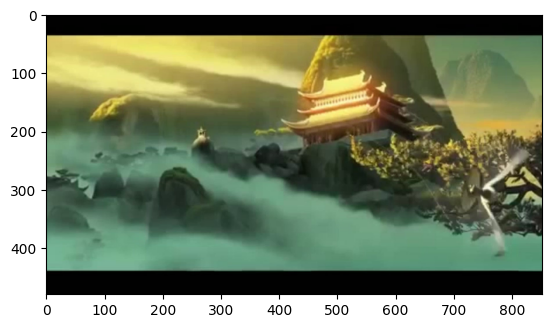

In [101]:
video2 = cv2.VideoCapture("/ar_source3.mp4")
ret, ar_frame = video2.read()
ar_frame = cv2.cvtColor(ar_frame, cv2.COLOR_BGR2RGB)
video2.release()
plt.imshow(ar_frame)


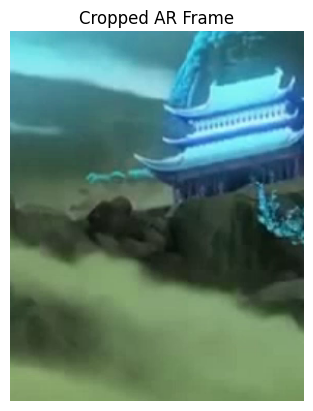

In [102]:
frame_height, frame_width = ar_frame.shape[:2]

# frame center
center_x = frame_width // 2
center_y = frame_height // 2

# crop coordinates
x_start = center_x - book_width // 2
y_start = center_y - book_height // 2
x_end = x_start + book_width
y_end = y_start + book_height

cropped_ar_frame = ar_frame[y_start:y_end, x_start:x_end]

plt.imshow(cv2.cvtColor(cropped_ar_frame, cv2.COLOR_BGR2RGB))
plt.title("Cropped AR Frame")
plt.axis('off')
plt.show()

### 1.5 Overlay the First Frame of the Two Videos

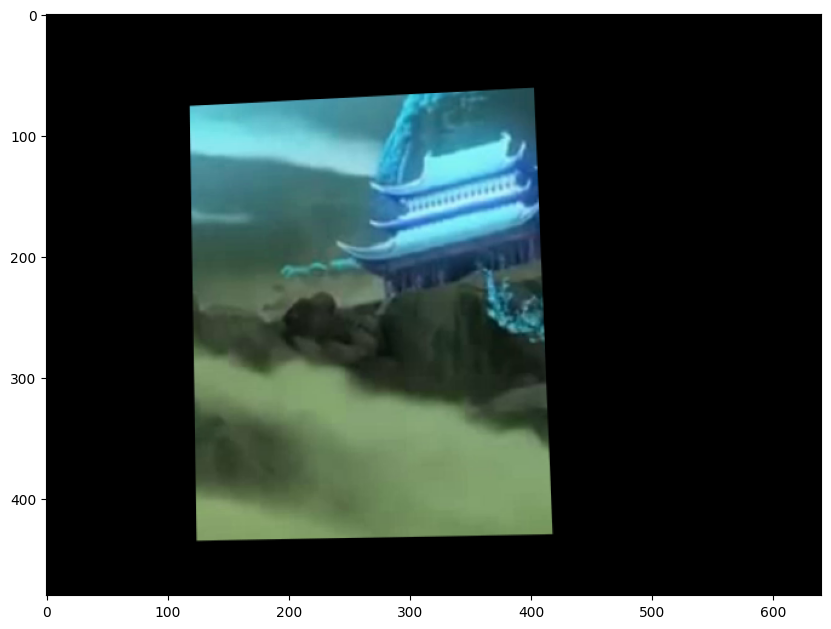

In [103]:
src_points = np.array([
    [0, 0],
    [book_width - 1, 0],
    [book_width - 1, book_height - 1],
    [0, book_height - 1]
])
dst_points = mapped_corners

# compute homography
H = compute_homography(src_points, dst_points)

# Warp the cropped movie frame onto the book size
warped_movie_frame = cv2.warpPerspective(cropped_ar_frame, H, (frame1.shape[1], frame1.shape[0]))
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(warped_movie_frame, cv2.COLOR_BGR2RGB))


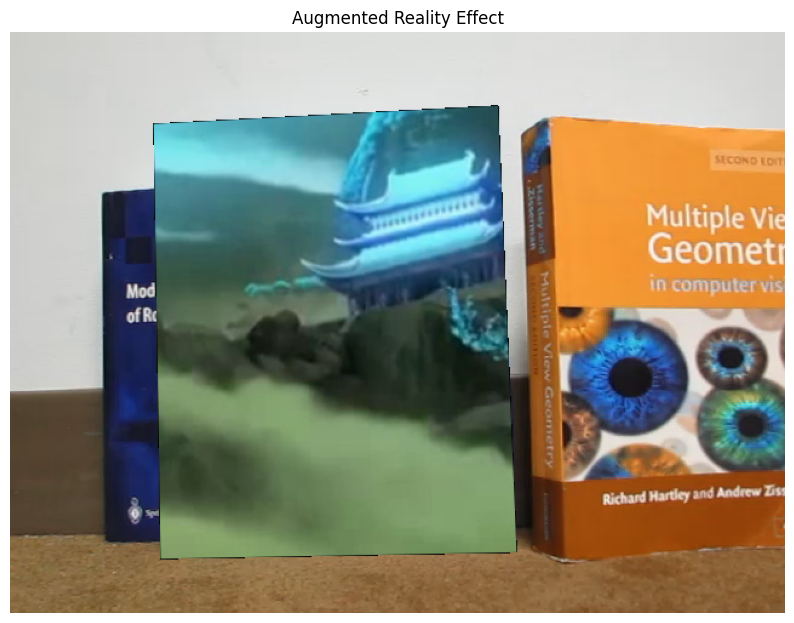

In [104]:
gray_warped = cv2.cvtColor(warped_movie_frame, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_warped, 1, 255, cv2.THRESH_BINARY)
mask_inverted = cv2.bitwise_not(mask)

frame1_bg = cv2.bitwise_and(frame1, frame1, mask= mask_inverted)
movie_fg = cv2.bitwise_and(warped_movie_frame, warped_movie_frame, mask= mask)

final_frame = cv2.add(frame1_bg, movie_fg)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(final_frame, cv2.COLOR_BGR2RGB))
plt.title('Augmented Reality Effect')
plt.axis('off')
plt.show()

### 1.6 Creating AR Application

In [105]:
cap_book = cv2.VideoCapture("/book.mov")
cap_ar = cv2.VideoCapture("/ar_source3.mp4")

out_frame_width = int(cap_book.get(cv2.CAP_PROP_FRAME_WIDTH))
out_frame_height = int(cap_book.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap_book.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_ar_video.avi', fourcc, fps, (out_frame_width, out_frame_height))

while True:
  ret_book, book_frame = cap_book.read()
  ret_ar, ar_frame = cap_ar.read()

  if not ret_book or not ret_ar:
        break

  kp1, kp2, good_matches = find_sift_matches(img1, book_frame)

  # Find Homography Parameters
  image1_points = []
  image2_points = []

  for m in good_matches:
    index1 = m.queryIdx
    index2 = m.trainIdx
    keypoint1 = kp1[index1]
    keypoint2 = kp2[index2]
    coordinates1 = keypoint1.pt
    coordiantes2 = keypoint2.pt

    image1_points.append(coordinates1)
    image2_points.append(coordiantes2)

  image1_points = np.array(image1_points, dtype=np.float32)
  image2_points = np.array(image2_points, dtype=np.float32)

  H = compute_homography(image1_points, image2_points)

  # Find book corners in book_frame
  height, width = img1.shape[:2]
  book_corners = np.array([
      [0, 0],
      [width - 1, 0],
      [width - 1, height - 1],
      [0, height - 1]
      ], dtype = np.float32)

  book_corners_homogeneous = np.hstack([book_corners, np.ones((4, 1))])
  mapped_corners = (H @ book_corners_homogeneous.T).T
  mapped_corners = mapped_corners[:, :2] / mapped_corners[:, 2, np.newaxis]

  # Get dimensions of the book
  book_width = np.linalg.norm(mapped_corners[0] - mapped_corners[1])
  book_height = np.linalg.norm(mapped_corners[3] - mapped_corners[0])
  book_width = int(round(book_width))
  book_height = int(round(book_height))

  # Compute Homography parameters
  src_points = np.array([
      [0, 0],
      [book_width - 1, 0],
      [book_width - 1, book_height - 1],
      [0, book_height - 1]
  ])
  dst_points = mapped_corners

  # compute homography
  H = compute_homography(src_points, dst_points)

  # Crop ar_frame
  frame_height, frame_width = ar_frame.shape[:2]
  center_x = frame_width // 2
  center_y = frame_height // 2

  x_start = center_x - book_width // 2
  y_start = center_y - book_height // 2
  x_end = x_start + book_width
  y_end = y_start + book_height

  cropped_ar_frame = ar_frame[y_start:y_end, x_start:x_end]

  warped_movie_frame = cv2.warpPerspective(cropped_ar_frame, H, (book_frame.shape[1], book_frame.shape[0]))

  # Overlay the 2 frames
  gray_warped = cv2.cvtColor(warped_movie_frame, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(gray_warped, 1, 255, cv2.THRESH_BINARY)
  mask_inverted = cv2.bitwise_not(mask)

  book_frame_bg = cv2.bitwise_and(book_frame, book_frame, mask= mask_inverted)
  movie_fg = cv2.bitwise_and(warped_movie_frame, warped_movie_frame, mask= mask)

  final_frame = cv2.add(book_frame_bg, movie_fg)

  out.write(final_frame)

cap_book.release()
cap_ar.release()
out.release()